# Prediction of NMR, X-ray and Mössbauer experimental results for amorphous Li-Si alloys using a novel DFTB model

This notebook contains the code needed to reproduce the results of our [arXiv article](https://arxiv.org/abs/2305.11006) where we propose nearest-neighbors models to predict experimental results in Silicon anodes, which hold a great promise for next-generation Li-ion batteries. 

**Disclaimers**
1. This will not follow the same order as the main text since the Supporting Material will be in the position where it is needed and not at the end of the notebook.
2. Data is available [here](https://github.com/fernandezfran/unveiled_LiSi_amorphous_structures), but we are going to use more extensive data for better statistics that cannot be uploaded to GitHub due to their size. We will also use NMR, X-ray and Mössbauer experimental data [[1](https://pubs.acs.org/doi/10.1021/ja8086278), [2](https://pubs.acs.org/doi/10.1021/ja108085d), [3](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.82.3460), [4](https://iopscience.iop.org/article/10.1149/1.3073879/meta)].

## Data collection

The data was obtained using [the set B of parameters](https://github.com/alexispaz/DFTB_LiSi/tree/main/lisi) for DFTB LiSi in [DFTB+ software](www.dftbplus.org), managed with a [lithiation code](https://github.com/fernandezfran/lithiation) that follows the protocol below:
1. Start with an [amorphous structure of silicon](https://pubs.acs.org/doi/full/10.1021/acs.jpca.3c00075).
2. Add a Li atom at the center of the largest spherical void (using voronoi vertices),
3. increase the volume and scale the coordinates by a factor to obtain the experimental expansion of the system.
4. Then, perform a NPT molecular dynamics equilibration for 10ps usign the Berendsen Thermostat and Barostat.
5. Repeat 2-4 steps until the desired number of Li atoms is reached.

In the script upload_data.py we have different functions to load the necessary data for each experiment.

In [1]:
%%capture
import upload_data

We import all the scientific Python libraries to be used in this Notebook

In [2]:
import itertools as it

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
import scipy.interpolate

## Distribution Functions

The Radial Distribution Function (RDF) describes the probability of finding an atom in a shell at a distance _r_ from a reference atom.

Calculation of the RDFs: Li-Li, Si-Li and Si-Si

In [3]:
%%capture
import MDAnalysis.analysis.rdf as mda_rdf

x, universes = upload_data.for_rdf()

nbins, rdfs = 100, {}

for i, (central, neighbor) in enumerate(zip(["Li", "Si", "Si"], ["Li", "Li", "Si"])):
    key = central + "-" + neighbor
    rdfs[key] = []
    
    for universe in universes:
        centrals = universe.select_atoms(f"name {central}")
        neighbors = universe.select_atoms(f"name {neighbor}")
        
        rdf = mda_rdf.InterRDF(centrals, neighbors, nbins=nbins, range=(0.0, 6.0), exclusion_block=(1, 1))
        rdf.run()
        
        rdfs[key].append(rdf.results.rdf)
    
bins = rdf.results.bins

Plot of the results

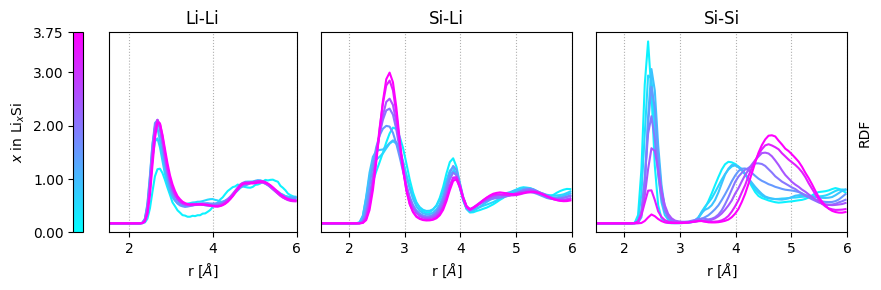

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 3))

cmap = cm.get_cmap("cool")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=3.75))
clb = fig.colorbar(sm, ax=ax[0], ticks=[0, 1, 2, 3, 3.75], location="left")
clb.ax.set_ylabel(r"$x$ in Li$_x$Si")

for i, (key, value) in enumerate(rdfs.items()):
    for j, rdf in enumerate(value):
        ax[i].plot(bins, rdf, color=cmap(x[j] / 3.75))
        
    ax[i].set_xlabel(r"r [$\AA$]")
    ax[i].set_xlim((1.5, 6))
    ax[i].grid(linestyle=":")
    
    ax[i].set_ylabel("")
    ax[i].set_yticks([])
    
    ax[i].set_title(key)

ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()
ax[2].set_ylabel("RDF")

fig.tight_layout()
plt.show()

The nature of the obtained distributions is typical for amorphous structures, having a definite first peak at short _r_ and decreasing following ones for increasing _r_. The decrease of the first peak and the shift of the one indicates that Si-Si bonds are being broken and isolated Si atoms appears.

These RDFs can be used to compute the Pair Distribution Funcition, _G(r)_

/home/ffernandez/.local/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


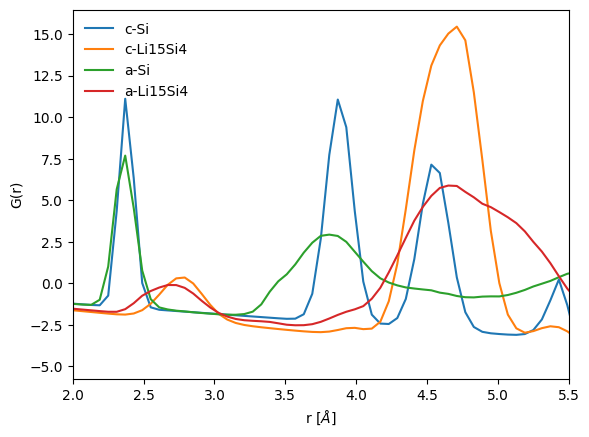

In [5]:
alloys, universes, laaziri, key = upload_data.for_gofrs()

atom_types = ("name Si", "name Li")

for alloy, u in zip(alloys, universes):
    if len(set(u.atoms.types)) == 1:
        weights = (1,)
        neighbors_types = (["all", "all"],)
    else:
        weights = (0.82, 0.16, 0.03)
        neighbors_types = it.combinations_with_replacement(atom_types, 2)
    
    trdf = np.zeros(nbins)
    
    for w, neighbor in zip(weights, neighbors_types):
        centrals = u.select_atoms(f"{neighbor[0]}")
        neighbors = u.select_atoms(f"{neighbor[1]}")
        
        rdf = mda_rdf.InterRDF(centrals, neighbors, nbins=nbins, range=(0, 6), exclusion_block=(1, 1))
        rdf.run()
        
        trdf += w * rdf.results.rdf
    
    r = rdf.results.bins
    
    natoms = len(u.atoms)
    volume = np.mean([np.prod(u.dimensions[:3]) for _ in u.trajectory])

    rho = natoms / volume
    
    gofr = 4 * np.pi * r * rho * (trdf - 1)
    
    plt.plot(r, gofr, label=alloy)
    
plt.xlim((2, 5.5))
plt.xlabel(r"r [$\AA$]")
plt.ylabel("G(r)")

plt.legend(frameon=False)
plt.show()

and compare with experiments

/home/ffernandez/.local/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


*** crystalline fitting ***
alloy	weight
c-Si: 0.033580
c-Li15Si4: 0.077784


/home/ffernandez/.local/lib/python3.9/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


*** DFTB fitting ***
alloy	weight
c-Si: 0.000000
c-Li15Si4: 0.036422
a-Si: 0.187970
a-Li15Si4: 0.147957


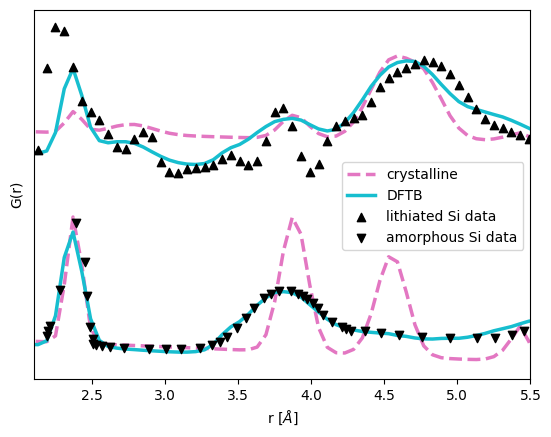

In [6]:
from macchiato.experiments.xray import PairDistributionFunction

fig, ax = plt.subplots()

r, target = key["r"].dropna(), key["4b"].dropna()
index = np.argsort(r)
r, target = r[index], target[index]
rmin = r.min()

for to, color, ls, label in zip([2, 4], ["tab:pink", "tab:cyan"], ["dashed", "solid"], ["crystalline", "DFTB"]):
    pdf = PairDistributionFunction(universes[:to])
    
    pdf.fit(r, target)
    pred = pdf.predict(pdf.rbins_)
    
    ax.plot(pdf.rbins_, 2 * (4 + pred), c=color, lw=2.5, ls=ls, label=label, zorder=1)

    print(f"*** {label} fitting ***")
    print(f"alloy\tweight")
    for w, alloy in zip(pdf.weights_, alloys[:to]):
        print(f"{alloy}: {w:.6f}")
        
ax.plot(pdf.rbins_, 0.8 * 0.5 * pdf.gofrs_[0], lw=2.5, ls="dashed", c="tab:pink", zorder=1)
ax.plot(pdf.rbins_, 0.5 * pdf.gofrs_[2], lw=2.5, c="tab:cyan", zorder=1)

rbins = pdf.rbins_[pdf.rbins_ > rmin]
gofr_exp = scipy.interpolate.interp1d(r, target)
ax.scatter(rbins, 2 * (4 + gofr_exp(rbins)), marker="^", c="k", label="lithiated Si data", zorder=2)
ax.scatter(
    laaziri.r,
    0.5 * 4 * np.pi * 0.04891375029364782 * laaziri.r * (laaziri.rdf - 1),
    c="k",
    marker="v",
    label="amorphous Si data",
    zorder=2,
)

ax.set_xlim((rmin, 5.5))
ax.set_yticks([])

ax.set_xlabel(r"r [$\AA$]")
ax.set_ylabel("G(r)")

ax.legend(loc=(0.62, 0.35))

plt.show()

## $^7$Li NMR chemical spectra

This Nuclear Magnetic Resonance (NMR) signal is characterized by a Voigt peak (V), which corresponds to the combination of a Lorentzian that is intrinsic to the NMR phenomena and a Gaussian due to the detector. Each Li atom introduce a shift on this signal that depends on the electromagnetic shielding caused by the local structure. We propose a nearest-neighbor model to emulate and interpret the features
in the NMR spectra, where a peak is obtained within the centers of each Li atom
$$
\delta_{\text{Li}} = \frac{1}{N_{\text{Si}}} \sum_{\text{Si} \in \textit{NN}} \delta_{\text{Key}},
$$
where the sum is over the Si nearest-neighbors (NN) and $\delta_{\text{Key}}$ can be 18 ppm if the Si neighbor is bonded and 6 ppm if it is isolated. Then the total spectra has an intensity
$$
I = \sum_{\text{Li} \in \text{Si}} V(\text{ppm}, \delta_{\text{Li}}, \sigma, \gamma),
$$
where $\sigma$ and $\gamma$ are the standard deviations and the half-width at half-maximum of gaussian and lorentzian components, respectively.

### Crystalline spectra

These atomic structures where obtained from [Materials Project](https://materialsproject.org/).

In [7]:
# code here

### Amorphous spectra

To facilitate the comparison with our model we includ a peak at -0.3 ppm, which represents the SEI contribution.

In [8]:
# code here

Discrepancies between model predictions and experiments stem from inhomogeneous lithiation that is not present in the simulated amorphous structures.

## Mössbauer spectra

This signal consist of two peaks that almost completely overlap at the extremes cases but are separeted for the intermediate cases. We reproduce the separation distance, $\Delta$, by tuning $a$ and $b$ parameters in
$$
\Delta = a \min\left\lbrace C_{\text{Li}}, C_{\text{Si}}\right\rbrace + b,
$$
where $C_{\text{Li}}$ and $C_{\text{Si}}$ are the concentration of Li and Si atoms.

In [9]:
# code here

An improvement is observed when considering the nearest-neighbors concentrations of the amorphous structures with respect to the overall concentrations.